In [ ]:
# Test script for classification
# Import packages

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from os.path import exists
import numpy as np
import pandas as pd
import os
import sys
import importlib

# Good idea to add this folder to the json.settings file as "python.analysis.extraPaths".
sys.path.append('../functionScripts/')

import plotFunctions # totalCountsPlot, data_heatmap, correlation_plot
import analysisFunctions
import initFunctions as initf #import createDirs, debugReport, loadLightSheetData
import classifyFunctions
import helperFunctions

importlib.reload(initf)

# Set Paths to data and output
dirDict = dict()
rootDir = 'C:\OneDrive\KwanLab\Lightsheet_cFos_Pipeline\\'
dirDict['atlasDir'] = rootDir + 'Atlas\\'
dirDict['dataDir'] = rootDir + 'Data\\'
dirDict['B1'] =       dirDict['dataDir'] + 'lightSheetV1\\'
dirDict['B2'] =       dirDict['dataDir'] + 'lightSheetV2Rev\\'   #3/6/23 - Looking at the new, Realigned batch 2 data. #Realigned
dirDict['B2_Orig'] =  dirDict['dataDir'] + 'lightSheetV2\\'
dirDict['B3'] =       dirDict['dataDir'] + 'lightSheetV3\\'      #3/6/23 - Batch 3 with MDMA

batchSplit = False          # Splits drugs from the first batch of data, from the second, from the 3rd. Batch 1 is labeled with 'a' (aSAL, aKET, aPSI), Batch 3 (cKET, MDMA)
splitTag  = ['a', '', 'c']  # Appended the to beginning of data from the first batch (PSI, KET, SAL -> aPSI, KET, aSAL).
testSplit = False           # Splits an individual drug for the sake of examining self-similarity
oldBatch2 = False

debugOutputs = False        # Saves csvs at intervals
scalingFactor = True        # Applies 1/total_cells as a scaling factor per mouse.
debug_ROI = ['Dorsal nucleus raphe']
outputFormat = 'png'

switchDir = dict(testSplit=testSplit, batchSplit=batchSplit, splitTag=splitTag, oldBatch2=oldBatch2, debugOutputs=debugOutputs, scalingFactor=scalingFactor, debug_ROI=debug_ROI, outputFormat=outputFormat)

# Make directories, and add their strings to the directory dictionary.
dirDict = initf.createDirs(rootDir, switchDir, dirDict)

In [ ]:
# Reload in case anything updated in these functions
importlib.reload(classifyFunctions)
importlib.reload(plotFunctions)
importlib.reload(helperFunctions)

# Set a random seed for reproducibility.
np.random.seed(seed = 31415)

classifyDict = dict()

# Parameters for pivoting the data
classifyDict['data'] = 'count_norm' #cell_density, count, count_norm, density_norm
classifyDict['feature'] = 'abbreviation'
classifyDict['label'] = 'class_KetPsi' #'drug', 'class_5HT2A', 'class_Trypt', 'class_KetPsi', 'class_PsiSSRI', 'class_5HTR', 'class_Speed', 'class_Psy_NMDA', 'class_SSRI'

# Parameters for feature scaling and aggregation
classifyDict['featurefilt'] = True
classifyDict['filtType'] = 'min' # Min removes the bottom 1%, Max removes the top 99th percentile.
classifyDict['featureAgg'] = False
classifyDict['featureSel_linkage'] = 'average'  # 'average', 'complete', 'single', 'ward' (if euclidean)
classifyDict['featureSel_distance'] = 'correlation' # 'correlation, 'cosine', 'euclidean'
classifyDict['cluster_count'] = 100 # Number of clusters to generate. Not used at the moment.
classifyDict['cluster_thres'] = 0.2 # Anything closer than this is merged into a cluster
 
# Parameters for Preprocessing and feature selection
classifyDict['model_featureTransform'] = True # True, False
classifyDict['model_featureScale'] = True # True, False
classifyDict['model_featureSel'] = 'Boruta' # 'Univar', 'mutInfo', 'RFE', 'MRMR', 'Fdr', 'Fwe_BH', 'Fwe', 'Boruta', 'None'
classifyDict['model_featureSel_alpha'] = 0.05 # Used for Fdr, Fwe, and Fwe_BH

# If Fdr/Fwe/None are not used for feature selection, the number of k feature must be preset
classifyDict['model_featureSel_mode'] = 'modelPer' # 'gridCV', 'modelPer'
# classifyDict['model_featureSel_k'] = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
classifyDict['model_featureSel_k'] = [30]

# Parameters for classification
classifyDict['model'] = 'LogRegL2' #'LogRegL2', 'LogRegL1', 'ElasticNet', 'LDA', 'RandomForest'
classifyDict['multiclass'] = 'multinomial' # 'ovr', 'multinomial'
classifyDict['max_iter'] = 100
classifyDict['CVstrat'] = 'ShuffleSplit' #'StratKFold', 'ShuffleSplit'

# ParamGrid Features - in instances where gridCV is set to true, these are the parameters that will be tested.
paramGrid = dict()
paramGrid['classif__l1_ratio'] = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]          # used for ElasticNet
# paramGrid['classif__C'] = [0.001, 0.01, 0.1, 1, 10]                    # used for LogisticRegression
paramGrid['classif__C'] = [1]                    # used for LogisticRegression
classifyDict['pGrid'] = paramGrid

classifyDict['shuffle'] = False
classifyDict['gridCV'] = False

if classifyDict['CVstrat'] == 'ShuffleSplit':
    classifyDict['CV_count'] = 100 # Number of folds for cross-validation
else:
    # K fold stratified can only afford n_classes of folds
    classifyDict['CV_count'] = 8 

if classifyDict['label'] == 'drug':
    classifyDict['test_size'] = 1/8
    classifyDict['innerFold'] = 7
else:
    classifyDict['test_size'] = 1/4
    classifyDict['innerFold'] = 4

classifyDict['saveLoadswitch'] = True
dirDict['uniqID'] = 'minThres'

# Load Pickle
lightsheet_data = pd.read_pickle('lightsheet_data.pkl') # lightsheet_data.pkl or lightsheet_all.pkl
lightsheet_data.loc[:, 'count_norm'] = lightsheet_data.loc[:, 'count']/lightsheet_data.loc[:, 'total_cells']
lightsheet_data.loc[:, 'density_norm'] = lightsheet_data.loc[:, 'count_norm']/lightsheet_data.loc[:, 'volume_(mm^3)']

lightsheet_data = lightsheet_data.fillna(0)

# Big Data - the dataset prior to filtering based on summary structures
# lightsheet_data = pd.read_pickle('lightsheet_data_big.pkl')
# lightsheet_data.rename(columns={'Brain Area': 'Brain_Area'}, inplace=True)

# Pure visualizations
# plotFunctions.meanCountPerRegion(lightsheet_data)
# lightsheet_data_filt = helperFunctions.filter_features(lightsheet_data, classifyDict)
# plotFunctions.histPrePostScale(lightsheet_data, ['count', 'count_norm'], dirDict)
# plotFunctions.data_heatmap(lightsheet_data, 'abbreviation', 'count', dirDict)
# plotFunctions.data_heatmap_single(lightsheet_data, 'abbreviation', 'count', dirDict) # cell_density, count, count_norm, density_norm

# Statistics
# lightsheet_data_filt = helperFunctions.filter_features(lightsheet_data, classifyDict)

# plotFunctions.distance_matrix(lightsheet_data, classifyDict, dirDict)
# plotFunctions.correlation_plot(lightsheet_data, classifyDict, dirDict)
# plotFunctions.correlation_plot_hier(lightsheet_data, classifyDict, dirDict)

# valRange = np.arange(1,9)
# grids = np.meshgrid(valRange, valRange, valRange, valRange, valRange, valRange, valRange, valRange)
# combinations = np.column_stack([grid.flatten() for grid in grids])
# classifyFunctions.bootstrap_fstat(lightsheet_data, classifyDict, dirDict)
# lightsheet_data['drug'] = lightsheet_data['drug'].replace('DMT', '5-MeO-DMT')

# classifyFunctions.classifySamples(lightsheet_data, classifyDict, dirDict)

95 96 97 98 99 

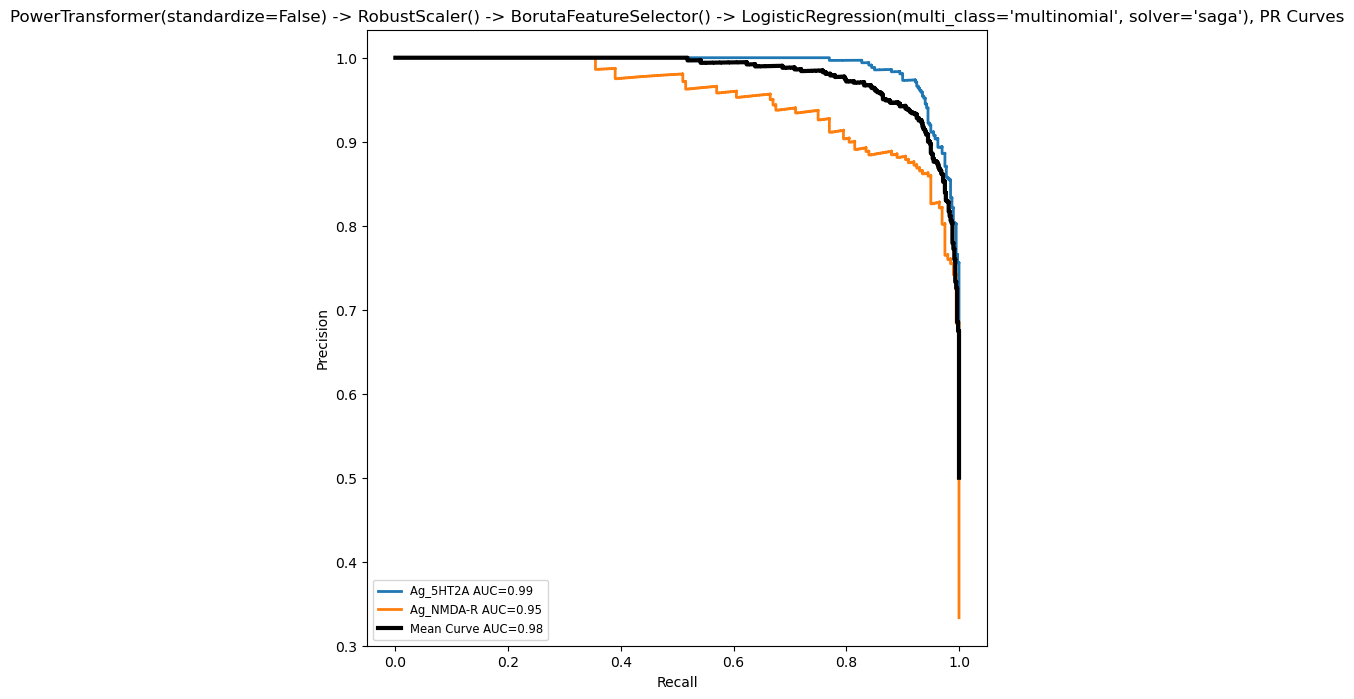

Real: 0.92 accuracy with a standard deviation of 0.12


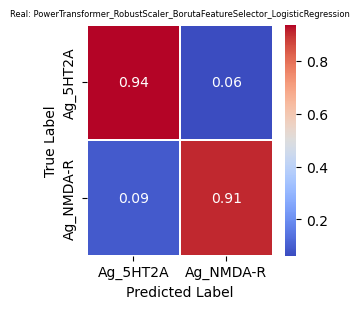

==== Ag_5HT2A vs Ag_NMDA-R ==== 
 Features per Model: [16, 8, 20, 11, 11, 15, 20, 15, 15, 12, 11, 15, 20, 21, 11, 8, 10, 8, 14, 17, 13, 14, 12, 17, 11, 13, 14, 11, 20, 14, 15, 11, 6, 17, 17, 14, 14, 16, 13, 12, 15, 14, 16, 20, 13, 15, 11, 17, 11, 16, 16, 11, 14, 19, 9, 16, 17, 10, 16, 17, 16, 16, 22, 11, 15, 11, 18, 16, 10, 12, 12, 11, 12, 14, 12, 13, 11, 10, 12, 14, 11, 9, 10, 15, 10, 13, 23, 11, 11, 18, 13, 11, 15, 18, 15, 14, 11, 12, 14, 15]
Parameters: 
 
Total Regions = 83 
 Present 1x: 16 - PRP, NOD, SIM, ProS, AN, MARN, IMD, ECU, LPO, PRNr, SPA, FOTU, I5, ACAd, IRN, AUDd
Present 2x: 5 - APr, MPN, MDRNd, SBPV, SSp-un
Present 3x: 9 - VISam, EPv, IAD, SSp-n, PoT, SAG, MDRN, MD, PR
Present 4x: 5 - GPe, PL, AVP, MA, ADP
Present 5x: 5 - CUN, GRN, NLOT, RSPv, LM
Present 6x: 2 - SPIV, SI
Present 7x: 4 - POST, PRE, PS, IA
Present 8x: 2 - PAR, MEPO
Present 9x: 4 - VISa, MT, AUDp, VISpm
Present 10x: 2 - DCO, CL
Present 11x: 3 - IP, FS, ORBvl
Present 13x: 4 - VISpl, TRN, COPY, LA
Present 16

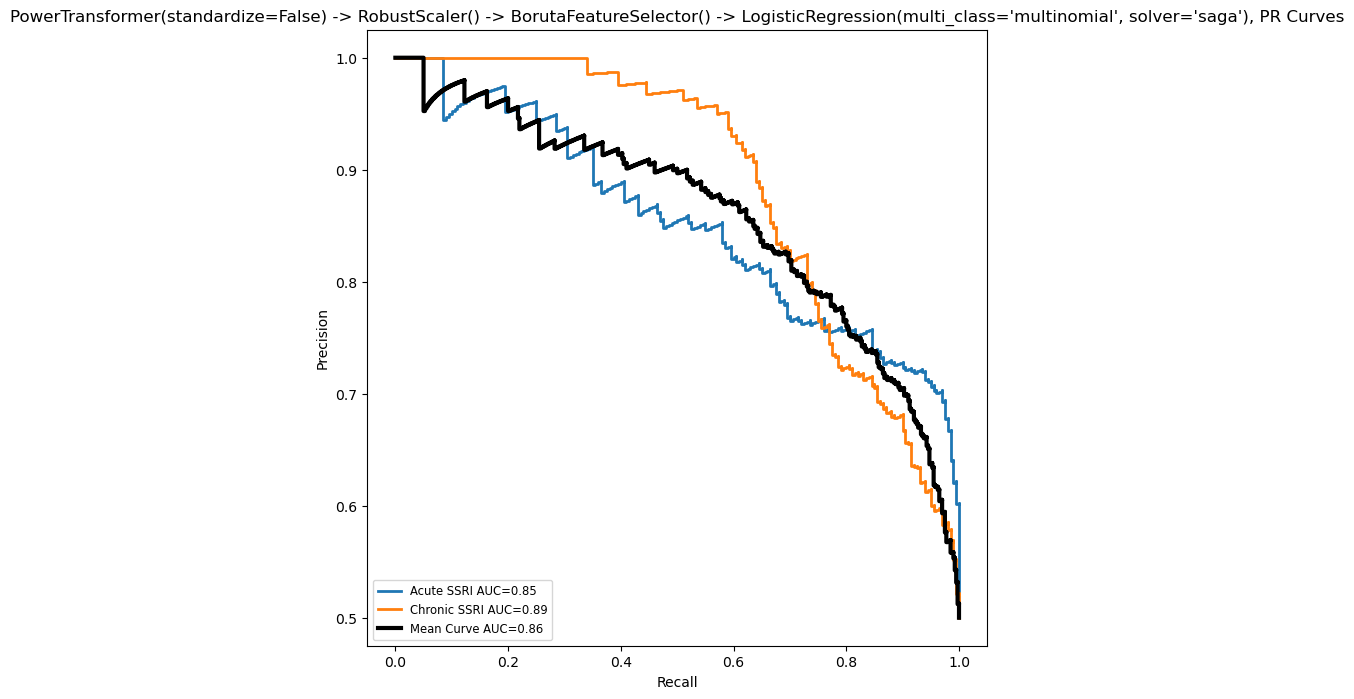

Real: 0.78 accuracy with a standard deviation of 0.20


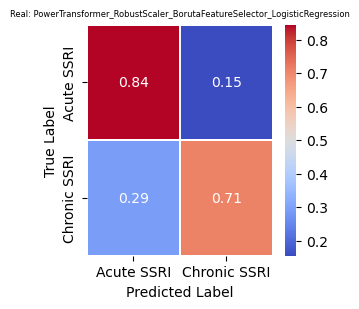

==== Acute SSRI vs Chronic SSRI ==== 
 Features per Model: [7, 9, 9, 8, 9, 10, 12, 13, 10, 6, 11, 8, 13, 6, 13, 11, 13, 4, 16, 11, 9, 12, 12, 8, 13, 10, 10, 7, 10, 9, 16, 6, 11, 6, 5, 11, 10, 10, 11, 11, 14, 10, 8, 12, 13, 9, 13, 6, 10, 9, 7, 7, 6, 8, 12, 9, 9, 9, 12, 10, 10, 7, 15, 8, 11, 11, 9, 6, 14, 13, 9, 8, 10, 8, 9, 10, 12, 8, 14, 13, 10, 9, 9, 10, 7, 10, 11, 10, 13, 10, 9, 6, 11, 13, 7, 10, 7, 14, 9, 7]
Parameters: 
 
Total Regions = 91 
 Present 1x: 24 - SBPV, IMD, III, SCm, ACB, NLOT, ZI, APr, SPVO, LP, RPO, P5, PRNr, VMH, SUT, RSPd, MOp, MEV, OP, AOB, FS, RL, CU, VISa
Present 2x: 12 - PSTN, CP, SNr, AId, FOTU, MDRN, RR, POL, SAG, AV, PeF, RT
Present 3x: 6 - SSp-m, MEPO, LSv, NOT, DTN, LGd
Present 4x: 5 - SCH, VPMpc, SFO, IAD, RSPv
Present 5x: 3 - MA3, VISl, ORBvl
Present 6x: 9 - SSp-n, VISC, V, NLL, I5, CL, LPO, NDB, PT
Present 7x: 1 - SUM
Present 8x: 1 - MDRNd
Present 9x: 1 - PVHd
Present 11x: 3 - SCs, COPY, PAA
Present 12x: 1 - IA
Present 13x: 2 - LING, SI
Present 14x: 1 -

In [4]:
# classifyVec = ['class_KetPsi', 'class_PsiSSRI', 'class_Trypt', 'class_DT', 'class_SSRI'] # 'drug', 'class_5HT2A', 'class_5HTR', 'class_Speed', 'class_Psy_NMDA', 'class_SSRI'
classifyVec = ['class_5HT2A', 'class_Trypt', 'class_PsiDMT', 'class_Speed', 'class_Psy_NMDA', 'class_SSRI']
classifyDict['model_featureSel'] = 'Boruta' # 'Univar', 'mutInfo', 'RFE', 'MRMR', 'Fdr', 'Fwe_BH', 'Fwe', 'Boruta', 'None'
classifyDict['model_featureSel_k'] = [10]

classifyDict['featurefilt'] = True

for i in classifyVec:
    try:
        print(f"Classifying {i}")
        classifyDict['label'] = i
        classifyFunctions.classifySamples(lightsheet_data, classifyDict, dirDict)
    except:
      print(f"\n Failed to classify {i}")


# classifyDict['featurefilt'] = False

# for i in classifyVec:
#     try:
#         print(f"Classifying {i}")
#         classifyDict['label'] = i
#         classifyFunctions.classifySamples(lightsheet_data, classifyDict, dirDict)
#     except:
#       print(f"\n Failed to classify {i}")